In [1]:
import numpy
from scipy import linalg, special, integrate
from scipy.integrate import solve_ivp
from matplotlib import pyplot
import matplotlib

#matplotlib.rc("font", **{"family":  "serif", "weight": "normal", "size": 20})

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": "28",
    "text.latex.preamble": "\\usepackage[utf8]{inputenc}\\usepackage[T1]{fontenc}\\usepackage{lmodern}"
})

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [30]:
d_ops, d_dags = bmme.generate_fermionic_ops(2)

omega = .003
g = .0075
t = .01
Gamma = .01
Gammas = numpy.zeros((2,2,2))
Gammas[1,1,0] = Gamma
T = .01 / bmme.k_B # 116

def func_H_s(x):
    H_s = .5 * omega * x[0]**2 * numpy.identity(d_ops[0].shape[0])
    H_s += g * x[0] * numpy.sqrt(2) * d_dags[0] @ d_ops[0]
    H_s += t * (d_dags[0] @ d_ops[1] + d_dags[1] @ d_ops[0])
    return H_s

def func_ddx_H_s(k, x):
    ddx = omega * x[0] * numpy.identity(d_ops[0].shape[0])
    ddx += g * numpy.sqrt(2) * d_dags[0] @ d_ops[0]
    return ddx

def diagonalize(matrix):
    return numpy.linalg.eig(matrix)

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, [val], d_ops, None, Gammas, 0, 0, T, T, diagonalize=diagonalize, include_digamma=False)

def my_func2(i, val):
    solver = bmme.general_solver(func_H_s([val]), d_ops, None, Gammas, 0, 0, T, T, diagonalize=diagonalize, include_digamma=False)
    r, L = solver.find_steady_state()
    return solver.V @ r @ solver.V_dag

x = numpy.linspace(-10, 10, 500)

mean_force1 = numpy.zeros(len(x), dtype=numpy.float64)
friction1 = numpy.zeros(len(x), dtype=numpy.float64)
correlation1 = numpy.zeros(len(x), dtype=numpy.float64)
rho1 = numpy.zeros((len(x), 4, 4), dtype=numpy.complex128)

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))
results2 = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func2)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-10:
        print("ALARM!!! Mean force")
    else:
        mean_force1[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-10:
        print("ALARM!!! Friction")
    else:
        friction1[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-10:
        print("ALARM!!! Correlation")
    else:
        correlation1[i] = results[i][2].real
        
for i in range(len(results2)):
    rho1[i] = results2[i]

Gamma = .02
Gammas = numpy.zeros((2,2,2))
Gammas[1,1,0] = Gamma
    
mean_force2 = numpy.zeros(len(x), dtype=numpy.float64)
friction2 = numpy.zeros(len(x), dtype=numpy.float64)
correlation2 = numpy.zeros(len(x), dtype=numpy.float64)
rho2 = numpy.zeros((len(x), 4, 4), dtype=numpy.complex128)

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))
results2 = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func2)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-10:
        print("ALARM!!! Mean force")
    else:
        mean_force2[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-10:
        print("ALARM!!! Friction")
    else:
        friction2[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-10:
        print("ALARM!!! Correlation")
    else:
        correlation2[i] = results[i][2].real
        
for i in range(len(results2)):
    rho2[i] = results2[i]

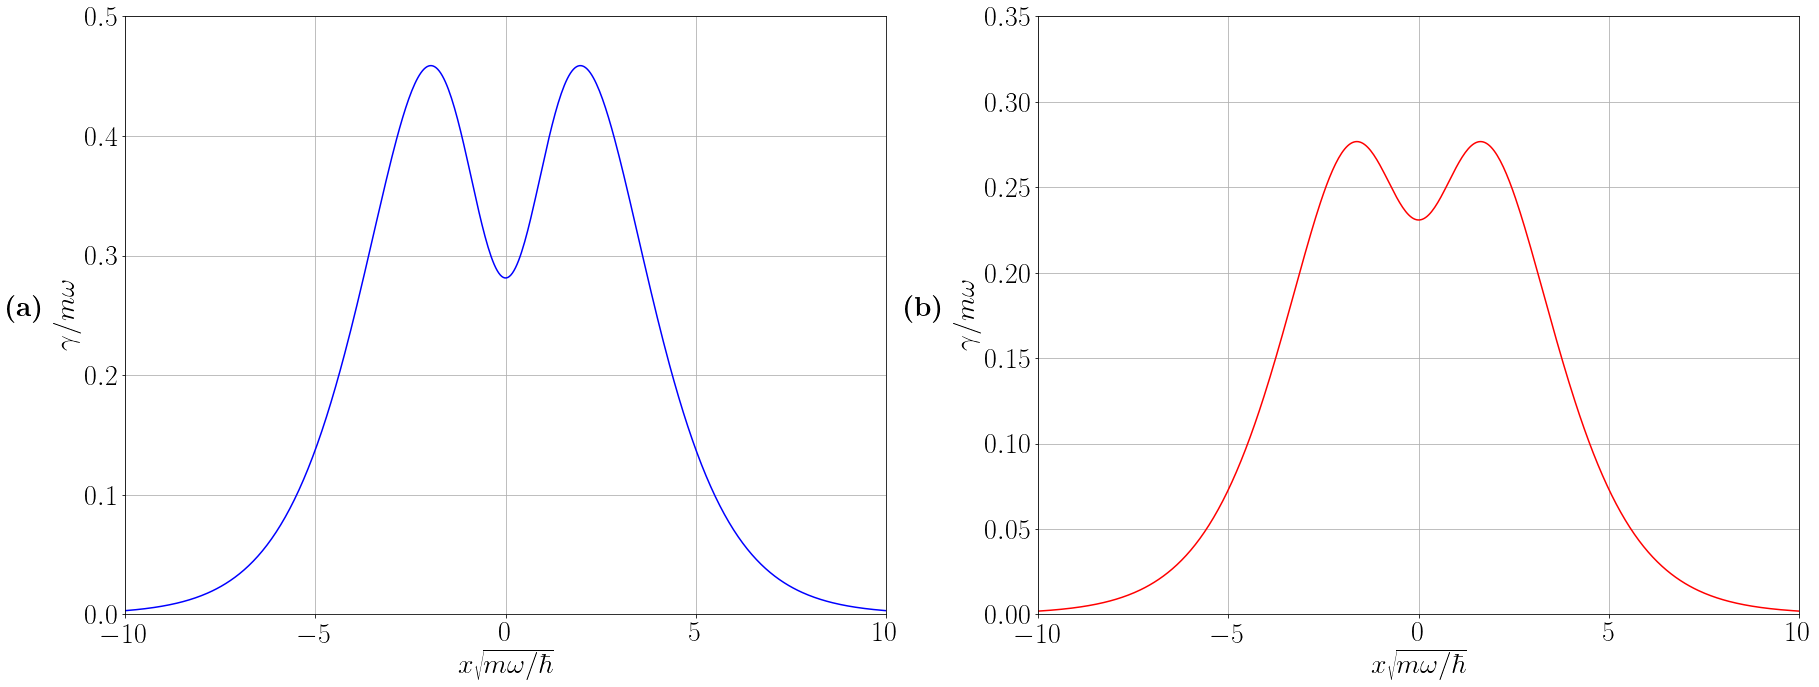

In [51]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(30, 11))

ax1.plot(x, bmme._hbar * friction1, c="blue")
#ax1.plot(x, bmme._hbar * correlation1 / (bmme.k_B * T), "--", c="red")
#ax1.plot(x, rho1[:,0,0])
#ax1.plot(x, rho1[:,1,1])
#ax1.plot(x, rho1[:,2,2])
#ax1.plot(x, rho1[:,3,3])
#ax1.plot(x, rho1[:,0,0]+rho1[:,1,1]+rho1[:,2,2]+rho1[:,3,3])
ax1.set_xlabel("$x\\sqrt{m\\omega/\\hbar}$")
ax1.set_ylabel("$\\gamma/m\\omega$")
ax1.set_xlim(-10, 10)
ax1.set_xticks([-10, -5, 0, 5, 10])
ax1.set_ylim(.0, .5)
ax1.set_yticks([.0, .1, .2, .3, .4, .5])
ax1.grid()
ax1.text(-13.1, .25, "\\textbf{(a)}")

ax2.plot(x, bmme._hbar * friction2, c="red")
ax2.set_xlabel("$x\\sqrt{m\\omega/\\hbar}$")
ax2.set_ylabel("$\\gamma/m\\omega$")
ax2.set_xlim(-10, 10)
ax2.set_xticks([-10, -5, 0, 5, 10])
ax2.set_ylim(.0, .35)
ax2.set_yticks([.0, .05, .1, .15, .2, .25, .3, .35])
ax2.grid()
ax2.text(-13.5, .175, "\\textbf{(b)}")

pyplot.savefig("qcle_cme1.pdf")
pyplot.show()

In [53]:
d_ops, d_dags = bmme.generate_fermionic_ops(2)

omega = .003
g = .0075
t = .0
Gamma = .01
Gammas = numpy.zeros((2,2,2))
Gammas[:,:,0] = [[Gamma, -Gamma], [-Gamma, Gamma]]
Delta = .01
T = .01 / bmme.k_B # 116
voltage = .0

def func_H_s(x):
    H_s = .5 * omega * x[0]**2 * numpy.identity(d_ops[0].shape[0])
    H_s += (g * x[0] * numpy.sqrt(0.5) - numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[0] @ d_ops[0]
    H_s += (g * x[0] * numpy.sqrt(0.5) + numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[1] @ d_ops[1]
    H_s += t * (d_dags[0] @ d_ops[1] + d_dags[1] @ d_ops[0])
    return H_s

def func_ddx_H_s(k, x):
    ddx = omega * x[0] * numpy.identity(d_ops[0].shape[0])
    ddx += (g * numpy.sqrt(0.5) - (g**2 / 2) * x[0] / numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[0] @ d_ops[0]
    ddx += (g * numpy.sqrt(0.5) + (g**2 / 2) * x[0] / numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[1] @ d_ops[1]
    return ddx

x = numpy.linspace(-10, 10, 500)

mean_force = numpy.zeros(len(x), dtype=numpy.float64)
friction = numpy.zeros(len(x), dtype=numpy.float64)
correlation = numpy.zeros(len(x), dtype=numpy.float64)
rho = numpy.zeros((len(x), 4, 4), dtype=numpy.complex128)

def diagonalize(matrix):
    return numpy.linalg.eig(matrix)

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, [val], d_ops, None, Gammas, -.5 * voltage, numpy.inf, T, T, diagonalize=diagonalize, include_digamma=False)

def my_func2(i, val):
    solver = bmme.general_solver(func_H_s([val]), d_ops, None, Gammas, -.5 * voltage, numpy.inf, T, T, diagonalize=diagonalize, include_digamma=False)
    r, L = solver.find_steady_state()
    return solver.V @ r @ solver.V_dag

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))
results2 = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func2)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-10:
        print("ALARM!!! Mean force")
    else:
        mean_force[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-10:
        print("ALARM!!! Friction")
    else:
        friction[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-10:
        print("ALARM!!! Correlation")
    else:
        correlation[i] = results[i][2].real
        
for i in range(len(results2)):
    rho[i] = results2[i]
        
#pmf = numpy.zeros(len(x), dtype=numpy.float64)
#for i in range(len(x)):
#    pmf[i] = -numpy.sum(mean_force[:i+1]) * (max(x) - min(x)) / (len(x) - 1)

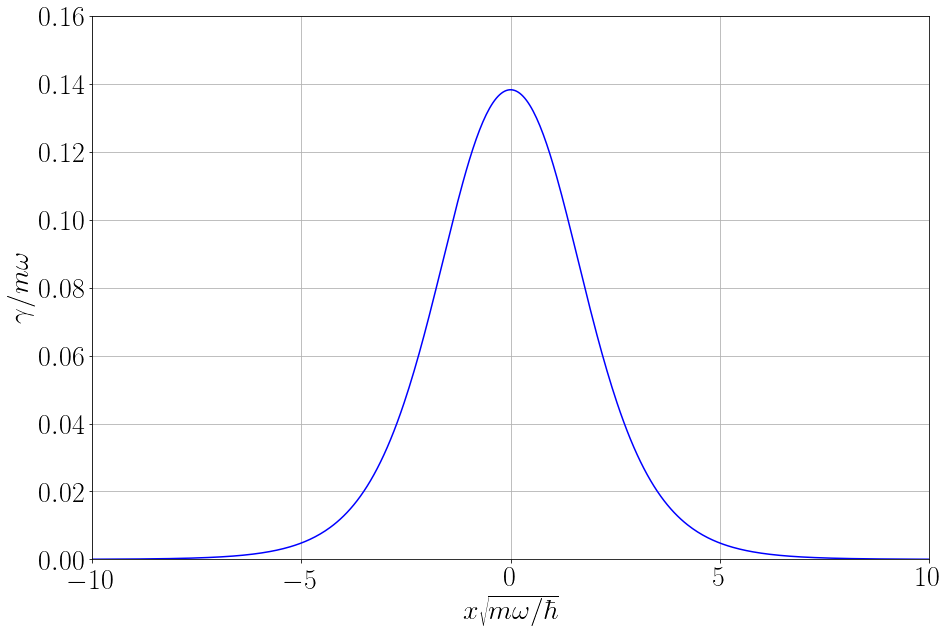

In [56]:
pyplot.figure(figsize=(15, 10))

#pyplot.plot(x, pmf-min(pmf))
pyplot.plot(x, bmme._hbar * friction, c="blue")
#pyplot.plot(x, bmme._hbar * correlation / (bmme.k_B * T), "--", c="red")
#pyplot.plot(x, rho[:,0,0])
#pyplot.plot(x, rho[:,1,1])
#pyplot.plot(x, rho[:,2,2])
#pyplot.plot(x, rho[:,3,3])
#pyplot.plot(x, rho[:,0,0]+rho[:,1,1]+rho[:,2,2]+rho[:,3,3])
pyplot.xlabel("$x\\sqrt{m\\omega/\\hbar}$")
pyplot.ylabel("$\\gamma/m\\omega$")
pyplot.xlim(-10, 10)
pyplot.xticks([-10, -5, 0, 5, 10])
pyplot.ylim(.0, .16)
pyplot.grid()
pyplot.savefig("qcle_cme2.pdf")
pyplot.show()